# Objective: properly format the annotations from the EPIC dataset to match the video file
 The metadata associated with the EPIC data does not preperly match the video, it would need some redistribution and reformatting in order to obtain better results from a deep learning model.

In [1]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shutil
from tqdm.notebook import tqdm


## Extracting all the frames from the videos
* Also had to remove the first and the last frames (with `frames_paths[1:-1]` ) from the list because they were corrupt

In [2]:
def threshold_image_np(raw_img, upper_gray_threshold, invert = False):  ## converts all pixels above upper_gray_threshold to 255 = white 
    
    if invert == True:
        ret,thresh1 = cv2.threshold(raw_img ,upper_gray_threshold,  255, cv2.THRESH_BINARY_INV)
    else:
        ret,thresh1 = cv2.threshold(raw_img ,upper_gray_threshold,  255, cv2.THRESH_BINARY)
    return thresh1


def preprocess_image(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    thresh = threshold_image_np(im, 15) 
    kernel = np.ones((3, 3), np.uint8) 
    eroded = cv2.erode(thresh, kernel) 
    dil = cv2.dilate(eroded,kernel,iterations = 2)
    
    final = cv2.bitwise_and(im, dil)
    
    return final

def video_to_frames(video_path, main_folder_path, sub_folder_path):
    frames_paths = []
    try:
        os.mkdir(main_folder_path + "/" + sub_folder_path)

    except:
        shutil.rmtree(main_folder_path + "/" + sub_folder_path)
        os.mkdir(main_folder_path + "/" + sub_folder_path)
        
    vidObj = cv2.VideoCapture(video_path)   
    success = 1
    count = 0
    while success: 
        success, image = vidObj.read() 
        fmt_name = main_folder_path + "/"+ sub_folder_path + "/" + str(count)+ ".jpg"
#         print(fmt_name)
        try:     
            
            image = preprocess_image(image)
            cv2.imwrite(fmt_name, image)
            frames_paths.append(fmt_name)
            count += 1
        except:
            pass 
    print ("saved ", count-1, " frames at ", main_folder_path + "/" + sub_folder_path)
    return frames_paths

In [84]:
frames_folder = "frames"

target_path = "videos/20080731_ceh-32_4_L1.mov"
frames_paths = video_to_frames(
                                video_path = target_path,
                                main_folder_path = frames_folder,
                                sub_folder_path = target_path[8:-4]
                               )
frames_paths = frames_paths[1:-1]
print("after removing bad frames in the beginning and the end : ", len(frames_paths))

saved  242  frames at  frames/0080731_ceh-32_4_L1
after removing bad frames in the beginning and the end :  241


## Some metadata from the website that would be useful
* Imaged Timepoints = 244
* Edited Timepoints = 130

So this means that there are 130 possible time values distributed  among the 244 frames in the video. Therefore we have to now distribute 24 frames among the 130 time stamps. 

In [9]:
def divide(lst, n):
    p = len(lst) // n
    if len(lst)-p > 0:
        return [lst[:p]] + divide(lst[p:], n-1)
    else:
        return [lst]
def chop_list(lst,num_chops ):
    p = len(lst) // num_chops
    if len(lst)-p > 0:
        return [lst[:p]] + divide(lst[p:], num_chops-1)
    else:
        return np.array([lst])

In [25]:
chopped_paths = np.array(chop_list(frames_paths , num_chops = 130))

## Viewing the new distribution
Since 244 / 130 is approximately 2, so there are 2 frames per time stamp mostly 

In [26]:
chopped_paths[20:25]

array([list(['frames/0080731_ceh-32_4_L1/23.jpg', 'frames/0080731_ceh-32_4_L1/24.jpg']),
       list(['frames/0080731_ceh-32_4_L1/25.jpg', 'frames/0080731_ceh-32_4_L1/26.jpg']),
       list(['frames/0080731_ceh-32_4_L1/27.jpg', 'frames/0080731_ceh-32_4_L1/28.jpg']),
       list(['frames/0080731_ceh-32_4_L1/29.jpg', 'frames/0080731_ceh-32_4_L1/30.jpg']),
       list(['frames/0080731_ceh-32_4_L1/31.jpg', 'frames/0080731_ceh-32_4_L1/32.jpg'])],
      dtype=object)

## Loading up the original annotations which can be found [here](http://epic.gs.washington.edu/details/ceh-32.html)

In [11]:
df = pd.read_csv("zipped_CD_Files/CD20080731_ceh-32_4_L1.csv")
df.head(5)

,cellTime,cell,time,none,global,local,blot,cross,z,x,y,size,gweight
0,ABa:2,ABa,2,23153,-1847,-375,-375,-1847,13.0,186,216,52,0
1,ABal:3,ABal,3,23352,-1648,-85,-145,-1536,13.1,178,227,56,0
2,ABal:4,ABal,4,23145,-1855,-284,-305,-1855,13.2,169,239,60,0
3,ABal:5,ABal,5,23414,-1586,-137,-137,-1586,13.3,160,251,64,729723
4,ABal:6,ABal,6,23942,-1058,145,145,-1058,14.7,139,267,66,1020349


In [7]:
def generate_compact_cellnames(cellname_column_values, size = 1):
    c = []
    for i in cellname_column_values:
        short = i[:size]
        c.append(short)
    return c 

def slice_df_wrt_cellname(df, compact_cellname):
    df_slice = df[df["compact_cellname"] == compact_cellname]
    return df_slice

## Adding a new column `compact_cellname`
 `compact_cellname` would give us info about the cell’s lineage (or the name of the cell itself, depending on the value of time) and not necessarily it’s precise name.`

In [13]:
df["compact_cellname"] = generate_compact_cellnames(df["cell"].values)
df.head()

,cellTime,cell,time,none,global,local,blot,cross,z,x,y,size,gweight,compact_cellname
0,ABa:2,ABa,2,23153,-1847,-375,-375,-1847,13.0,186,216,52,0,A
1,ABal:3,ABal,3,23352,-1648,-85,-145,-1536,13.1,178,227,56,0,A
2,ABal:4,ABal,4,23145,-1855,-284,-305,-1855,13.2,169,239,60,0,A
3,ABal:5,ABal,5,23414,-1586,-137,-137,-1586,13.3,160,251,64,729723,A
4,ABal:6,ABal,6,23942,-1058,145,145,-1058,14.7,139,267,66,1020349,A


## Finding the population of each cell family at a given time 
* `find_num_cells_with_time()` is pretty self explanatory, finds the number of cells for all possible time values in the dataset
*  `generate_cell_wise_population_plots()`generates a 2D array with the time values and the respective lineage population for each cell family 

In [3]:
def find_num_cells(df, time_val):
    df_time = df[df["time"] == time_val]
    return len(df_time.cell.unique())

def find_num_cells_with_time(df):
    times = df.time.unique()
    num_cells = [find_num_cells(df, time) for time in times]
    
    return times, num_cells # x, y axis 

def generate_cell_wise_population_plots(df):
    compact_cellnames = df["compact_cellname"].unique()
    plots =  []
    for name in compact_cellnames:
        sliced_df = slice_df_wrt_cellname(df, compact_cellname = name)

        times , num_cells = find_num_cells_with_time(sliced_df)
        plots.append([times, num_cells])
    return np.array(plots)

In [30]:
plots = generate_cell_wise_population_plots(df)

## Plotting the population with respect to time 

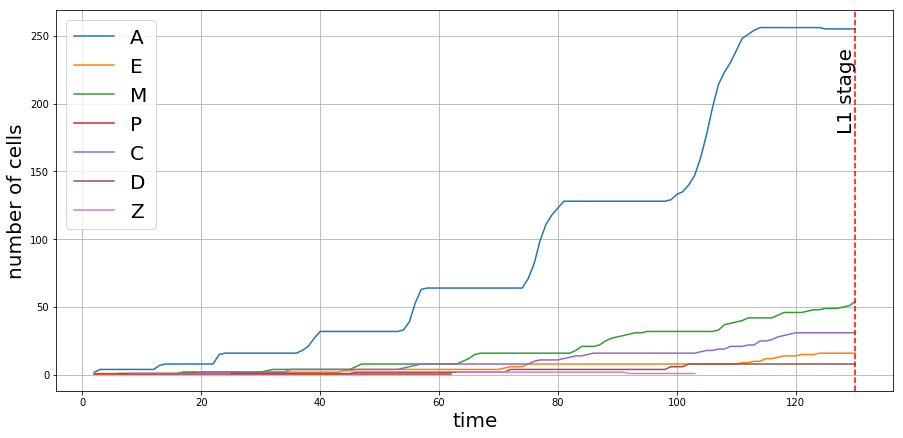

In [31]:
plt.rcParams['figure.figsize'] =15, 7

compact_cellnames = df["compact_cellname"].unique()

for i in range (len(plots)):
    plt.plot(plots[i][0], plots[i][1], label = compact_cellnames[i] )

    
plt.grid()
plt.axvline(x = 130, linestyle = "--", color = "red")
plt.text(x = 127, y = 230, s = 'L1 stage',rotation=90, fontsize = 20)
plt.legend(fontsize = 20)
plt.xlabel("time", fontsize = 20)
plt.ylabel("number of cells", fontsize = 20)
plt.show()

In [32]:
compact_cellnames

array(['A', 'E', 'M', 'P', 'C', 'D', 'Z'], dtype=object)

In [33]:
populations = [pop[1] for pop in plots]
ideal_len = len(populations[0])

for i in range (len(populations)):
    row = populations[i]
    
    while len(row) <= ideal_len:
        row.insert(0,0)
    populations[i] = row
    
populations = np.array(populations)
print(populations.shape)

(7, 130)


## Transposing the data to get the population of each family with time 
This would be a much better format for deep learning models to train upon

In [34]:
pop_transpose = np.transpose(populations)
print ("shape = ", pop_transpose.shape)
pop_transpose[:5]

shape =  (130, 7)


array([[0, 0, 0, 0, 0, 0, 0],
       [2, 1, 0, 0, 0, 0, 0],
       [4, 1, 0, 0, 0, 0, 0],
       [4, 1, 0, 0, 0, 0, 0],
       [4, 1, 0, 0, 0, 0, 0]])

In [35]:
final_data= []
for i in range(len(chopped_paths)):
    row = chopped_paths[i]
    for name in row:
        data_row = pop_transpose[i]
        final_data.append(data_row)
final_data = np.array(final_data)

In [36]:
filenames  = pd.DataFrame(frames_paths)
# print(filenames.head())
filenames.columns = ["filenames"]

train_df = pd.DataFrame(final_data)
train_df.columns = compact_cellnames

train_df = pd.concat([filenames, train_df], axis = 1)
train_df.head(10)

,filenames,A,E,M,P,C,D,Z
0,frames/0080731_ceh-32_4_L1/1.jpg,0,0,0,0,0,0,0
1,frames/0080731_ceh-32_4_L1/2.jpg,2,1,0,0,0,0,0
2,frames/0080731_ceh-32_4_L1/3.jpg,4,1,0,0,0,0,0
3,frames/0080731_ceh-32_4_L1/4.jpg,4,1,0,0,0,0,0
4,frames/0080731_ceh-32_4_L1/5.jpg,4,1,0,0,0,0,0
5,frames/0080731_ceh-32_4_L1/6.jpg,4,1,1,0,0,0,0
6,frames/0080731_ceh-32_4_L1/7.jpg,4,1,1,0,0,0,0
7,frames/0080731_ceh-32_4_L1/8.jpg,4,1,1,0,1,0,0
8,frames/0080731_ceh-32_4_L1/9.jpg,4,1,1,0,1,0,0
9,frames/0080731_ceh-32_4_L1/10.jpg,4,1,1,0,1,0,0


## Scale up for multiple video files 
* Basically the same process as above but in one single function 

In [12]:
def video_csv_pairs_to_training_data(video_path,csv_path, main_foldername, drop_first_last_frame = True):
    
    df = pd.read_csv(csv_path)
    
    df["compact_cellname"] = generate_compact_cellnames(df["cell"].values)
    compact_cellnames = df["compact_cellname"].unique()
    sub_foldername = video_path[7:-4]
#     print(sub_foldername)
    
    
    if len(compact_cellnames) == 7:
        
        
        frames_paths = video_to_frames(
                                video_path = video_path,
                                main_folder_path = main_foldername,
                                sub_folder_path = sub_foldername
                               )
        if drop_first_last_frame == True:
            frames_paths = frames_paths[1:-1]
            
            
        times = df.time.unique()
        num_chops = len(times)
        chopped_paths = np.array(chop_list(frames_paths , num_chops = num_chops))
        
    
        plots = generate_cell_wise_population_plots(df)

        populations = [pop[1] for pop in plots]
        ideal_len = len(populations[0])

        for i in range (len(populations)):
            row = populations[i]

            while len(row) <= ideal_len:
                row.insert(0,0)
            populations[i] = row

        populations = np.array(populations)
        pop_transpose = np.transpose(populations)

        final_data= []
        for i in range(len(chopped_paths)):
            row = chopped_paths[i]
            for name in row:
                data_row = pop_transpose[i]
                final_data.append(data_row)
        final_data = np.array(final_data)    

        filenames  = pd.DataFrame(frames_paths)
        filenames.columns = ["filenames"]

        train_df = pd.DataFrame(final_data)
#         print(compact_cellnames)
        train_df.columns = compact_cellnames

        train_df = pd.concat([filenames, train_df], axis = 1)
#         print(train_df.head())

        return train_df
    else:
        print(" \n skipped ", csv_path, "because it doesn't contain all the cell lineages \n")
        return None

In [85]:
train_df_2 = video_csv_pairs_to_training_data(video_path = "videos/20080731_ceh-32_4_L2.mov",
                                 csv_path = "zipped_CD_Files/CD20080731_ceh-32_4_L2.csv", 
                                 main_foldername = "frames")

saved  242  frames at  frames/0080731_ceh-32_4_L2


In [15]:
def mass_conversion_to_frames_and_build_training_data(videos_folder, csv_folder, frames_foldername):
    videos = os.listdir(videos_folder)
    ids = [i[:-4] for i in videos]
    
    dfs = []
    
    for i in tqdm(range(len(ids))):
        csv_filename = csv_folder + "/" + "CD" + ids[i] + ".csv"
        video_filename = videos_folder + "/" + ids[i] + ".mov"
        
        try:
            df = video_csv_pairs_to_training_data(video_path = video_filename,
                                             csv_path = csv_filename, 
                                             main_foldername = frames_foldername)
        except:
            print(" \n **********         error occurred, skipping...        ********* \n ")
        if df is not None:
            dfs.append(df)
    return dfs

In [16]:
!rm -rf frames/*
dfs = mass_conversion_to_frames_and_build_training_data(videos_folder = "videos",
                                                  csv_folder = "zipped_CD_Files",
                                                  frames_foldername = "frames")


saved  272  frames at  frames/20091023_dpy-31_3_L2
saved  241  frames at  frames/20090217_eor-1_9G1_13_L1
saved  272  frames at  frames/20080709_ceh-27_1_L1
 
 skipped  zipped_CD_Files/CD20090225_nob-1_L2.csv because it doesn't contain all the cell lineages 

saved  388  frames at  frames/20080305_c50f7_5_7
saved  267  frames at  frames/20080829_T23G4_1_1_L1
saved  222  frames at  frames/20090218hlh1AF16
saved  272  frames at  frames/20090529_nob-1_b26_L1
saved  272  frames at  frames/20080828_F38C2_7_12_L2
 
 skipped  zipped_CD_Files/CD20060704_RW10029_cnd1_9.csv because it doesn't contain all the cell lineages 

saved  244  frames at  frames/20081002_moe-3_8_L1
 
 skipped  zipped_CD_Files/CD20060818_pha4_b2.csv because it doesn't contain all the cell lineages 

saved  153  frames at  frames/20071031_tbx-38_3
saved  261  frames at  frames/20081014_ref-1_2_L1
saved  378  frames at  frames/20070719_lin-39_10
saved  227  frames at  frames/20090605_nob-1_b26_L1
saved  253  frames at  fram

saved  244  frames at  frames/20090331_fkh-4_11D3b24
 
 skipped  zipped_CD_Files/CD20070904_hlh-1_4.csv because it doesn't contain all the cell lineages 

saved  351  frames at  frames/20060627_cnd1_4-2
saved  255  frames at  frames/20090430_F21A10_2_9_L1
saved  265  frames at  frames/20080708_tbx-8_7G2_1_L2
saved  234  frames at  frames/20080902_ceh-36B4_L1
saved  242  frames at  frames/20090316PHA-4_AF16_L2
saved  383  frames at  frames/20080507_pha-4_3E3C5_1
saved  248  frames at  frames/20080822_ceh-36b4_L1
saved  262  frames at  frames/20090701_elt-6_RW10178_L1
saved  298  frames at  frames/011505_end1red_bright
saved  188  frames at  frames/20090415_fkh-4_11D3b24_L2
saved  222  frames at  frames/20090328PHA-4AF16_L1
saved  253  frames at  frames/20080914_ceh-21_6_L2
saved  247  frames at  frames/20080429_cnd-1_3C3_11
saved  233  frames at  frames/20090806_F58D2_1_2_L1
saved  383  frames at  frames/20070804_mml-1_5
saved  239  frames at  frames/20090519_F09G2_9_6_L1
saved  267  fr

 
 skipped  zipped_CD_Files/CD20081024_K02G10_1_4_L1.csv because it doesn't contain all the cell lineages 

saved  369  frames at  frames/20080219_sdz-28_4
saved  267  frames at  frames/20091119_lir-2_OP175_L1
saved  383  frames at  frames/20080507_pha-4_3E3C5_1xx
saved  245  frames at  frames/20090511_isw-1_3_L1



## Concatenating the data for the 2 different files that were processed and saving them /


In [17]:
final_df = pd.concat(dfs, axis = 0, sort = False)
print(final_df.info())
final_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62602 entries, 0 to 243
Data columns (total 8 columns):
filenames    62602 non-null object
A            62602 non-null int64
E            62602 non-null int64
M            62602 non-null int64
P            62602 non-null int64
C            62602 non-null int64
D            62602 non-null int64
Z            62602 non-null int64
dtypes: int64(7), object(1)
memory usage: 4.3+ MB
None


,filenames,A,E,M,P,C,D,Z
0,frames/20091023_dpy-31_3_L2/1.jpg,0,0,0,0,0,0,0
1,frames/20091023_dpy-31_3_L2/2.jpg,2,0,0,0,0,0,0
2,frames/20091023_dpy-31_3_L2/3.jpg,2,0,0,0,0,0,0
3,frames/20091023_dpy-31_3_L2/4.jpg,2,0,0,0,0,0,0
4,frames/20091023_dpy-31_3_L2/5.jpg,3,0,0,0,0,0,0


In [18]:
final_df.to_csv("data/training_data.csv", index = False)